# Reddit API Script to collect posts and perform sentiment analysis

In [3]:
import pandas as pd
import numpy as np

import time
from datetime import datetime

import praw # reddit API crawler

import nltk # Sentiment analysis module
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import sys
import os
import csv

from deep_translator import GoogleTranslator

Only need to run this for first run, it downloads the VADER lexicon, punkt tokenizer and stop word library

In [113]:

def downloadNLTK():

    nltk.download('vader_lexicon')  # get lexicons data
    nltk.download('punkt')  # for tokenizer
    nltk.download('stopwords')

#downloadNLTK()

Credentials for Reddit API

In [114]:
username = 'balackdynamite' # Personal Reddit Account
id = 'RcSucsCZw-A0pEmsaaqaQA'
secret = 'oIF0qAUUXuh9QtbsgOJwwQM9j4vJLw'

As I am getting posts from non english speaking subreddits I can see potential issues in getting sentiment scores. I am going to use google translate to change the titles to be all in english.

In [115]:
def translateText(data,lang='en'):

    try:
        translation = GoogleTranslator(source='auto', target=lang).translate(data)

    except:
        translation = data

    if translation == None:
        return data

    else:
        return translation

I also would like to tokenize my titles and remove stop words to help imrpve the accuracy of sentiment scores

In [116]:
def listToString(s):
    str1 = " "
    return (str1.join(s))

In [117]:
def cleanText(text):

    stop_words = stopwords.words('english') # stop words from nltk module

    text = text.replace("'", "").replace("-", "").lower() # removing quotes and dashes

    tk = nltk.tokenize.RegexpTokenizer(r'\w+') #split up text into words
    tokens = tk.tokenize(text)

    words = [w for w in tokens if not w in stop_words]

    text = listToString(words) # convert back to string sentence

    return text

In [118]:
def dataframeSentiment(data):

    s = SentimentIntensityAnalyzer()

    res = data['Title'].apply(lambda x: pd.Series(s.polarity_scores(x)))

    data = pd.concat([data, res], axis=1)

    return data

Threshold values need to be selected to classify the titels into labels: Positive, Negative and Neutral

From research a value of 0.05 is typically used as optimal: https://www.researchgate.net/figure/Typical-threshold-values-used-in-VADER-20_fig5_350761338


In [119]:
def dataframeSentimentLabel(data,threshold=0.05):

    conditions = [
        (data['compound'] <= -threshold),
        (data['compound'] > -threshold) & (data['compound'] < threshold),
        (data['compound'] >= threshold),
        ]

    values = ["neg", "neu", "pos"]
    data['label'] = np.select(conditions, values)

    return data

In [120]:
def sentimentAnalysis(data):

    data = dataframeSentiment(data)

    data = dataframeSentimentLabel(data)

    return data

Initial Test of scraping post titles using the Reddit API

subreddit = 'ireland' # subreddit we want to scrape
postLimit = 10 # the amount of posts we want, None = All of them

subreddit = r.subreddit(subreddit)

posts = [*subreddit.top(limit=postLimit)] # top posts all time

titles = [posts.title for posts in posts] # list of title of posts

posts = pd.DataFrame({"title": titles,})

posts.head()

In [121]:
keywords = ['housing market', 'housing', 'property', 'real estate', 'construction', 'building', 'infrastructure', 'labor', 'wages']
subredditList = ['ireland', 'europe', 'germany', 'france']
#postLimit = int(1000/len(subredditList)) # 1000 is the max value allowed by Reddit API, so divide the limit by N number of subreddits to be searched
postLimit = 10 # 1000 is the max value allowed by Reddit API

startTime = time.time_ns()

cols = ["Subreddit",'Original Title',"Title"]
cols += keywords

germanKeywords = [translateText(word,'de') for word in keywords ]

frenchKeywords = [translateText(word,'fr') for word in keywords ]

keywordsMatch = keywords + germanKeywords + frenchKeywords

# keywordsMatch = [word for word in keywordsMatch if word is not None] # remove invalid translations - None types

data = pd.DataFrame(columns = cols)

for subreddit in subredditList:

    r = praw.Reddit(user_agent=username,
                client_id=id,
                client_secret=secret,
                check_for_async=False)

    s = r.subreddit(subreddit)

    for w in keywords:

        for submission in s.search(w, limit=postLimit):

            created = datetime.utcfromtimestamp(submission.created_utc).year
            submission = submission.title


            ogTitle = submission

            #print(ogTitle)

            submission = translateText(submission) # translate titles to english

            #print(f"After Translate: {submission}")

            submission = cleanText(submission) # function to tokenize, remove stop words and make sentence

            #print(f"After Clean Text: {submission}")

            row = {'Subreddit': subreddit,
                   'Original Title': ogTitle,
                   'Title': submission,
                   'Created':created}

            match = 0

            for keyword in keywordsMatch:

                if keyword in ogTitle.lower():
                    match = 1
                    row['Match'] = match
                else:
                    match = 0

                if keyword in germanKeywords:

                    position = germanKeywords.index(keyword)
                    word = keywords[position] # take the english word for it

                    if word in row:

                        if row[word] == 1: # already have a match for that word in this title
                            continue

                elif keyword in frenchKeywords:

                    position = frenchKeywords.index(keyword)
                    word = keywords[position]

                    if word in row:

                        if row[word] == 1:
                            continue

                else:
                    word = keyword

                row[word] = match

                if match ==1 :
                    #print(f'Title: {ogTitle.lower()} found {word}')
                    pass

            data = pd.concat([data, pd.DataFrame([row])], ignore_index=True)

data = sentimentAnalysis(data) # function gets sentiment scores and labels them based on threshold value

endTime = time.time_ns()

runTimeSeconds = int(endTime - startTime)/1000000000

print(f'Running analysis on {len(data)} posts with a limit of {postLimit} took {runTimeSeconds} seconds')


Running analysis on 4634 posts with a limit of 150 took 1242.1639261 seconds


Time analysis data from trial and error:

Running analysis on 6579 posts with a limit of 500 took 1851.6176345 seconds
Running analysis on 3325 posts with a limit of 100 took 883.0920258 seconds



In [122]:
filename = 'EfficiencyredditAPI.csv'
exists = os.path.isfile(filename)

with open(filename, 'a', newline='') as file:
    writer = csv.writer(file)

    if not exists:
        headers = ['Posts', 'Limit', 'Duration']
        writer.writerow(headers)

    # Append latest values
    latest_values = [len(data), postLimit, runTimeSeconds]
    writer.writerow(latest_values)

Exporting to file and using the current datetime to timestamp it, this ensures each file is unique in value as the frequency of running this is greater than 1 minute naturally, if this was scaled up to run asynchronously and in millisecond time we'd need to optimize the code and file name structure.

In [123]:
now = datetime.now().replace(microsecond=0)

fileName = 'redditSentiment-' + str(now).replace(":","-") + '.csv'

data.to_csv(fileName,index=False)

Charts for Sentiment Analysis and Time Analysis

In [1]:

filename = 'finalRedditSentiment.csv'

df = pd.read_csv(filename)

df.head()

NameError: name 'pd' is not defined

In [ ]:
topic_columns = ['housing market', 'housing', 'property', 'real estate', 'construction', 'building', 'infrastructure', 'labor', 'wages']

sentiment_count = pd.DataFrame(columns=['topic', 'neg', 'neu', 'pos'])

for column in topic_columns:
    sentiment_df = df[df[column]==1]

    neg_count = sentiment_df['label'].value_counts().get('neg', 0)
    neu_count = sentiment_df['label'].value_counts().get('neu', 0)
    pos_count = sentiment_df['label'].value_counts().get('pos', 0)

    new_row_data = {
        'topic': [column],
        'neg': [neg_count],
        'neu': [neu_count],
        'pos': [pos_count]
    }

    new_row = pd.DataFrame(new_row_data)

    sentiment_count = pd.concat([sentiment_count, new_row], ignore_index=True)

sentiment_count.set_index('topic').plot(kind='bar')
plt.title('Sentiment Count by Topic')
plt.xlabel('Topic')
plt.ylabel('Count')
plt.show()

In [ ]:
topic_columns = ['housing market', 'housing', 'property', 'real estate', 'construction', 'building', 'infrastructure', 'labor', 'wages']

for column in topic_columns:
    sentiment_count = pd.DataFrame(columns=['subreddit', 'neg', 'neu', 'pos'])
    topic_df = df[df[column]==1]
    for subreddit in topic_df['Subreddit'].unique():
        sentiment_df = topic_df[topic_df['Subreddit'] == subreddit]
        new_row = pd.DataFrame({'subreddit': [subreddit],
                                'neg': [sentiment_df['label'].value_counts().get('neg', 0)],
                                'neu': [sentiment_df['label'].value_counts().get('neu', 0)],
                                'pos': [sentiment_df['label'].value_counts().get('pos', 0)]})
        sentiment_count = pd.concat([sentiment_count, new_row], ignore_index=True)
    sentiment_count.set_index('subreddit').plot(kind='bar')
    plt.title(f'Sentiment Count for topic {column}')
    plt.xlabel('Subreddit')
    plt.ylabel('Count')
    plt.show()

In [ ]:

df['Year'] = df['Created'].astype(int)

sentiment_mapping = {'neg': -1, 'neu': 0, 'pos': 1}
df['sentiment_value'] = df['label'].map(sentiment_mapping)

topic_columns = ['housing market', 'housing', 'property', 'real estate', 'construction', 'building', 'infrastructure', 'labor', 'wages']

#average sentiment for each topic by year
for column in topic_columns:
    topic_df = df[df[column] == 1]
    avg_sentiment_by_year = topic_df.groupby('Year')['sentiment_value'].mean()

    avg_sentiment_by_year.plot()
    plt.title(f'Average Sentiment for {column} Over Years')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment')
    plt.show()

## Efficiency of Reddit API

In [4]:
filename = 'EfficiencyredditAPI.csv'

df = pd.read_csv(filename)

df.head()

,Posts,Limit,Duration
0,360,10,168.130527
1,3326,100,914.333998
2,3325,100,883.090000
3,6579,500,1851.617000
4,6583,1000,1851.055285


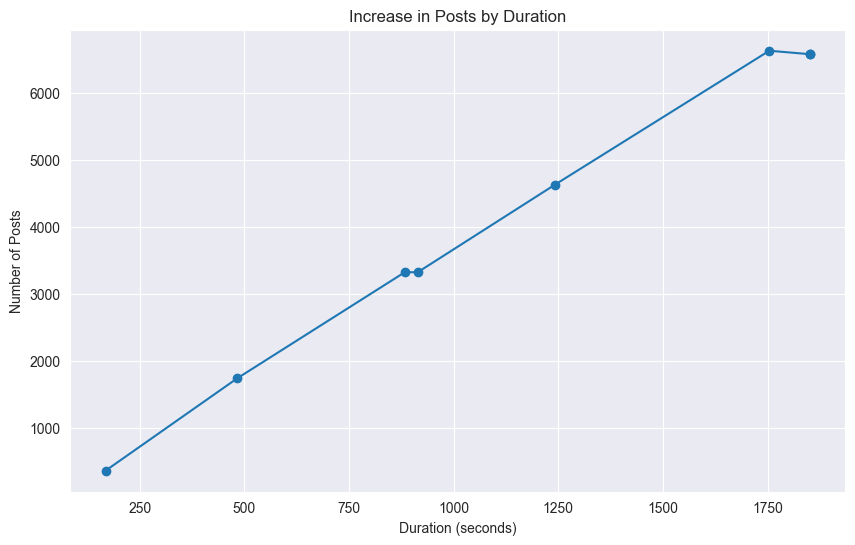

In [5]:
df = df.sort_values('Duration')

plt.figure(figsize=(10, 6))
plt.plot(df['Duration'], df['Posts'], marker='o')
plt.title('Increase in Posts by Duration')
plt.xlabel('Duration (seconds)')
plt.ylabel('Number of Posts')
plt.grid(True)
plt.show()

In [6]:
slope, intercept = np.polyfit(df['Duration'], df['Posts'], 1)

print(f"The rate of increase in Duration is {round(slope,3)} posts per second")

The rate of increase in Duration is 3.698 posts per second
